## Inference over a planar robotic arm - edit
This model implements a state-space model for rigid body dynamics of the robotic arm.

Our state-space $\mathbf{x} \in \mathbb{R}^6 $ includes torques $\tau_i$, angles $\theta_i$ and angular velocities $\dot{\theta}_i$. We append all static parameters in $\phi = \{L_{1}, L_{2}, M_{1}, M_{2}\}$.

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = \tau_1 \\  \mathbf{x}_2 = \tau_2 \\ \mathbf{x}_3 =\theta_1 \\ \mathbf{x}_4 =\theta_2 \\
\mathbf{x}_5 = \dot{\theta}_1 \\ \mathbf{x}_6 = \dot{\theta}_2 \end{pmatrix}, \quad \mathbf{\dot{x}} = \begin{pmatrix} -\lambda \mathbf{x}_1 + \sigma_{\tau}*\epsilon_1 \\  -\lambda \mathbf{x}_2 + \sigma_{\tau}*\epsilon_2 \\ \mathbf{x}_5 \\ \mathbf{x}_6 \\ \mathbf{D}^{-1}(\mathbf{x}_4, \phi) [\begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix} - \mathbf{c}(\mathbf{x}_3, \mathbf{x}_4) -\mathbf{h}(\mathbf{x}_4, \mathbf{x}_5, \mathbf{x}_6) ]
\end{pmatrix}  := a(\mathbf{x})
$$

Where $\mathbf{D} \in \mathbb{R}^{2 \times 2}$ is the inertia tensor and $\mathbf{c},\mathbf{h} \in \mathbb{R}^{2}$ are gravity and fictitious forces vectors, respectively, and $\epsilon \sim \mathcal{N}(0,1)$.

Note that $a(\mathbf{x})$ is non-linear because (1) the operation $\mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}$, and (2) $\mathbf{c},\mathbf{h}$ are non-linear functions of the state.

with noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0\\0\\0\end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ 0 \\ 0 \\ 0 \\0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ \sigma \\ \sigma \\ \sigma \\\sigma \end{pmatrix} \nu_t
 $$

where we introduce $\sigma<<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a(\mathbf{x}_t), \text{diag}(\Delta{t}^2,\Delta{t}^2, \sigma, \sigma, \sigma, \sigma))
$$

The emission is 

$$
g(\mathbf{y}_t | \mathbf{x}_t) = \text{FW-KIN}(\mathbf{x}_3, \mathbf{x}_4)
$$

## Concepts Explored in this notebook
The full model from torques to coordinates $\mathbf{\tau} \rightarrow \mathbf{y}$ can be estimated properly with enough independent SMC samplers. In this implementation, the batch dimension of each tensor is used as an independent SMC sampler.

For parameter learning $\theta : = \{M_1, M_2, L_1, L_2\}$, we do not need to use SMC samplers; `batch_size` could be small, even 1. in each SGD iteration, I estimate the states $\mathbf{x}$. Some SGD iterations will be good and some bad, but we assume that they're good enough. Then, offline, we use many independent particle filters.

In [1]:
import os
import inspect
print('Running in:')
print(os.getcwd())
plot_folder = 'planar_arm_dyn_plots'

Running in:
/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test


In [2]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)

In [3]:
print('Parent directory:')
parent_dir

Parent directory:


'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc'

In [4]:
# change dir to import from aesmc
os.chdir(parent_dir)
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state
import aesmc.math as math
from aesmc.smoothing import smooth_result
#import aesmc.smoothing as smoothing # older, when functions were disparate

In [5]:
# change dir to import from aesmc/test
os.chdir(current_dir)
from arm_models import planar_arm_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords
from arm_models import utils_summary
#from arm_models import fw_sim_planar_arm_dyn
from arm_models import proposal_objects

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [7]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [10]:
# running params
num_timesteps = 200
saving_interval = 10
logging_interval = 10
batch_size = 64 # 64 is good for independent SMC. the higher the better.
num_iterations = 500
num_particles = 1000

In [11]:
# define global model params
dt = 0.03 # time interval between observations
g = 1.0 # gravity 
dim_latents = 6 # always 6 in the full planar arm model.
transition_force_scale = 20.0 # 20.0 was best also for data; tried also 10, 30, 50
transition_aux_scale = ((dt**2)*transition_force_scale**2) / (10.0) #* 2
initial_loc = 0.0 # natural choice.
torque_init_scale = 1.0 
theta_init_scale = 1.0
velocity_init_scale = 1.0
emission_var_diag = 0.05 #note this value! 1.0 # was 0.1 before. this varies with the application. 
print('torque effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

torque effective variance: 0.36000
auxilliary variance: 0.03600


In [12]:
inits_dict = {}
inits_dict["L1"] = 1.0  # 2.0
inits_dict["L2"] = 1.0  # 2.0
inits_dict["M1"] = 0.5  # 1.1
inits_dict["M2"] = 0.3  # 1.2
# put params into dicts
param_dict = {}
param_dict["init_mu"] = initial_loc * np.ones(dim_latents)
param_dict["init_cov"] = np.diag(
    np.concatenate([np.repeat(torque_init_scale**2, 2),
                    np.repeat(theta_init_scale**2, 2),
                   np.repeat(velocity_init_scale**2, 2)])) # not using initial_scale.

In [13]:
# initialize arm model, used by transition and proposal.
arm_model_instance = planar_arm_dyn_model.PlanarArmDyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=False,
    constrain_phase_space=False,
    torque_dyn="Langevin")
# below is an attempt to scale Langevin_lambda with the transition force scale
arm_model_instance.Langevin_lambda = transition_force_scale * .3 # was * .3
arm_model_instance.Langevin_lambda

6.0

In [14]:
list(arm_model_instance.parameters())

[Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(0.5000),
 Parameter containing:
 tensor(0.3000)]

In [15]:
full_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
we use it to simulate ground truth data, and inference. 
with realistic data, params will have to be learned.'''

full_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

full_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_instance)

full_model["emission"] = planar_arm_dyn_model.Emission(
    inits_dict,  #ToDo: inits_dict is now redundant for L1,L2
    np.eye(6) * emission_var_diag,
    arm_model_instance,
    theta_indices=[2, 3])

### Proposal options:
#### Bootstrap proposal:
`proposal = proposal_objects.Bootstrap_Proposal_Short( \
                                initial, transition)`
     
#### Optimal proposal (only if emission model is linear):
`proposal = proposal_objects.Optimal_Proposal(initial, transition, emission)`

#### Learned proposal:
`proposal = proposal_objects.Learned_Proposal(initial, transition, emission, num_hidden_units, dim_obs)`

In [16]:
full_model["proposal"] = proposal_objects.Bootstrap_Proposal( \
                               full_model["initial"], full_model["transition"])
# full_model["proposal"] = proposal_objects.Learned_Proposal( \
#                                full_model["initial"], 
#                                 full_model["transition"],
#                                 20,
#                                 6)

## Simulate from full model and infer states
Can we infer the true dynamics?

In [17]:
np.random.seed(0)
torch.manual_seed(0)

In [18]:
# simulate from full model.
sim_lats, sim_observs = statistics.sim_data_from_model(full_model, 
                                            num_timesteps,
                                            batch_size, True)
# if simulating from a deterministic model

repeating data in batch.


In [19]:
# concatenate and convert to numpy; for plotting.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

if torch.cuda.is_available():
    lat_data_np = lat_data.detach().cpu().numpy()
    sim_data_np = sim_data.detach().cpu().numpy()
else:
    lat_data_np = lat_data.detach().numpy()
    sim_data_np = sim_data.detach().numpy()


torch.Size([64, 6, 200])
torch.Size([64, 6, 200])


In [20]:
# labels for plots.
label_dict_full = {}
label_dict_full["state"] = [r'$\tau_1$', r'$\tau_2$', 
              r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']
label_dict_full["obs"] = [r'$x_0$', r'$y_0$',
                     r'$x_1$', r'$y_1$',
                  r'$x_2$', r'$y_2$']

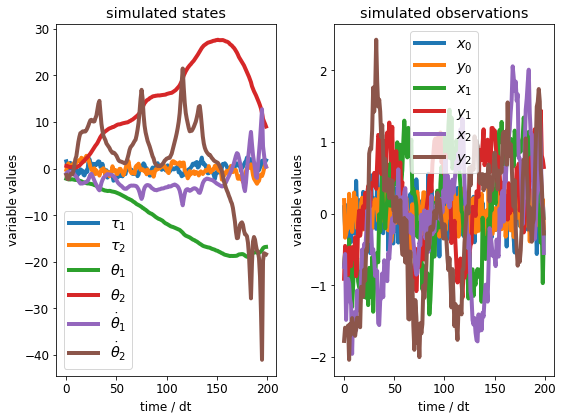

In [23]:
ind_in_batch = 8
arm_utils.plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict_full,
                       plot_folder + '/sim_dataset.png')

In [24]:
# from scipy.special import logsumexp # sometimes needed.

In [25]:
inference_result = inference.infer_latents(full_model, 
                                 sim_observs, 
                                 num_particles)

run time for 200 timesteps, 64 batches, 1000 particles = 100.96


In [26]:
inference_result = utils_summary.send_inference_result_to_cpu(inference_result)

In [27]:
# send tensors to cpu if they were on GPU
if torch.cuda.is_available():
    keys = inference_result.keys()
    for key in keys:
        #print(key)
        if type(inference_result[key]) is torch.Tensor:
            inference_result[key] = inference_result[key].cpu()
        elif type(inference_result[key]) is list:
            if len(inference_result[key]) > 0:
                for i in range(len(inference_result[key])):
                    inference_result[key][i] = inference_result[key][i].cpu()

In [28]:
# summarize posterior separately for each batch element.
# if batches are identical, each includes an independent SMC sample
posterior_summary = utils_summary.summarize_posterior(inference_result)

applying uniform average of 64 SMC samplers.
applying weighted average of 64 SMC samplers.


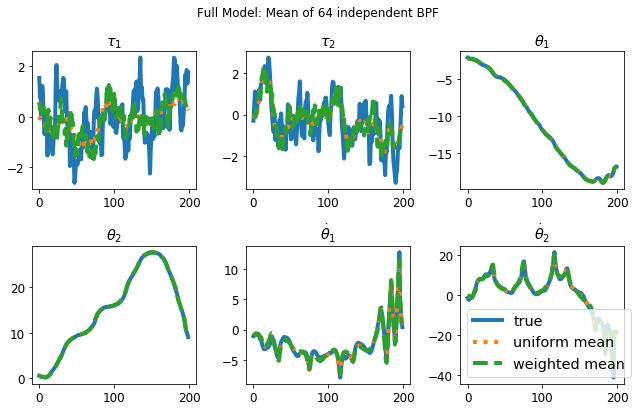

In [29]:
## comparison of uniform and weighted means

# uniform:
mean, var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=None,
    method='uniform')
# weighted:
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)  

# plot the two estimates.
f, axarr = plt.subplots(2, 3, figsize=(9, 6))
axarr = axarr.flatten()
for i in range(lat_data_np.shape[1]):
    axarr[i].plot(lat_data_np[0, i, :], label='true')
    axarr[i].plot(mean[i, :], linestyle='dotted', label='uniform mean')
    axarr[i].plot(weighted_mean[i, :],
                  linestyle='dashed',
                  label='weighted mean')
    axarr[i].set_title(label_dict_full["state"][i])
    if i == lat_data_np.shape[1] - 1:
        plt.legend()
f.suptitle('Full Model: Mean of %i independent BPF' % batch_size)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(plot_folder + '/mean_of_16_filters_grav.png')

(array([24]),)


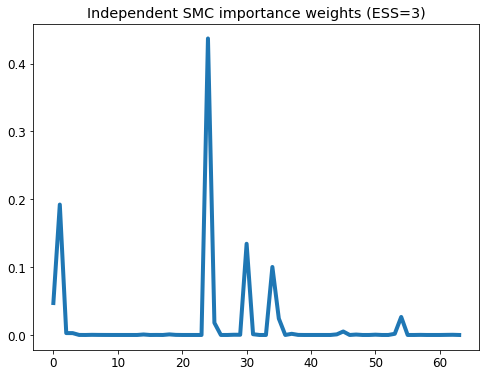

In [30]:
from scipy.special import logsumexp
logw = inference_result["log_marginal_likelihood"].detach().numpy()
w = np.exp(logw - logsumexp(logw))
plt.plot(w)
print(np.where(w==np.max(w)))
independent_SMC_ESS = 1.0 / np.sum(w**2)
#print('independent SMC ESS: %d' % independent_SMC_ESS)
plt.title('Independent SMC importance weights (ESS=%d)' % independent_SMC_ESS)
plt.savefig(os.path.join(plot_folder, 'ind_smc_importance_weights.png'))

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


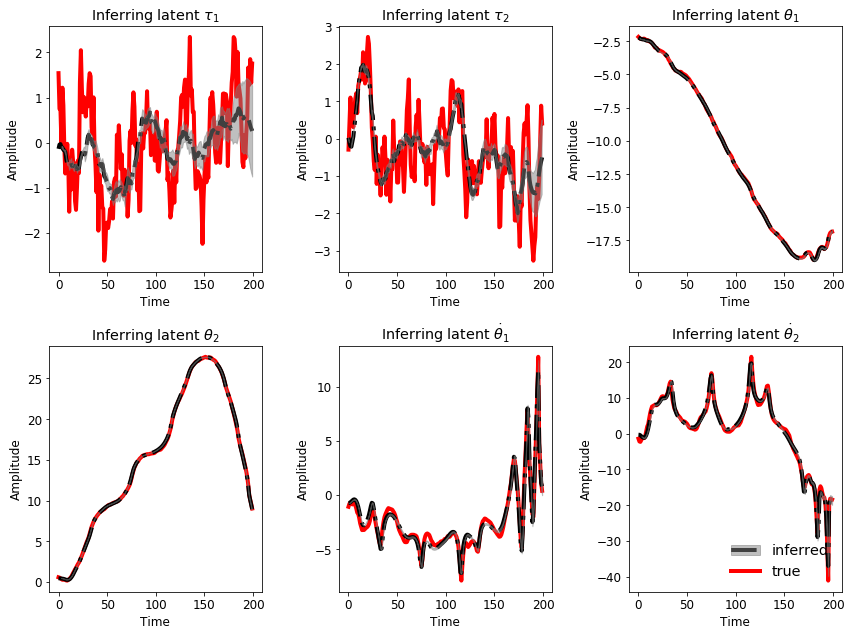

In [31]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/uniform.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=mean[i,:],
    post_var=np.sqrt(var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


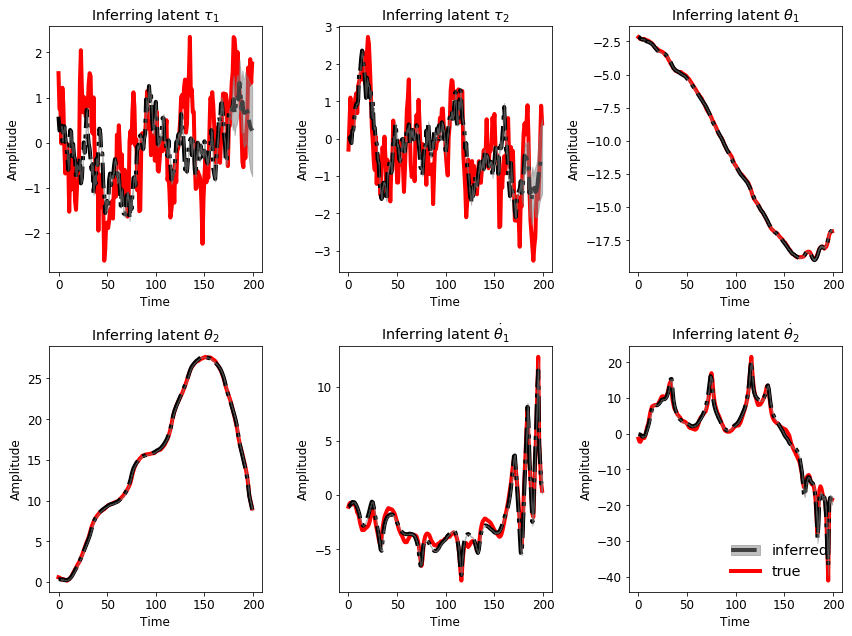

In [32]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/weighted.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_mean[i,:],
    post_var=np.sqrt(weighted_var[i,:]),
    data_vec= lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

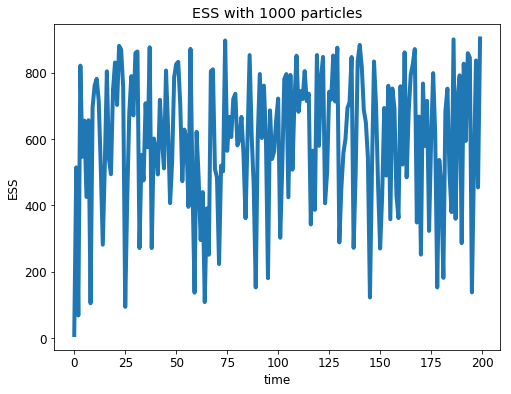

In [43]:
# plot ESS
ind_in_batch = 41
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_1.png')

In [34]:
# # noiseless simulated observations (sim_data_np is with noise)
# x_obs, y_obs = arm_utils.coords_from_params_mat(
#    lat_data_np[ind_in_batch,2,:], 
#     lat_data_np[ind_in_batch,3,:], 
#                 inits_dict["L1"], inits_dict["L2"]) 

# noisy 
x_obs = sim_data_np[ind_in_batch,[0,2,4],:].T
y_obs = sim_data_np[ind_in_batch,[1,3,5],:].T

print('observed x and y shapes')
print(x_obs.shape, y_obs.shape)

# reconstruction
# this is the version for weighted average of BPFs
x_hat , y_hat = arm_utils.coords_from_params_mat(
   weighted_mean[2,:], 
    weighted_mean[3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
print('reconstructed x and y shapes')
print(x_hat.shape, y_hat.shape)

observed x and y shapes
(200, 3) (200, 3)
reconstructed x and y shapes
(200, 3) (200, 3)


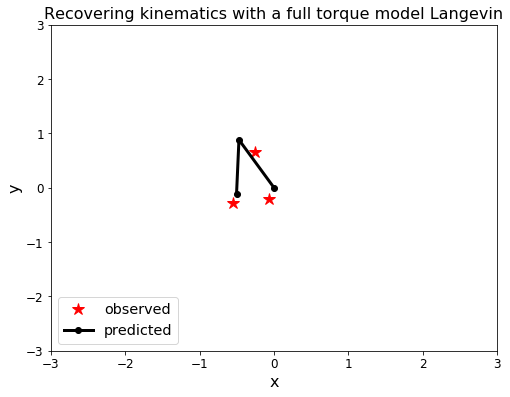

In [35]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             plot_folder+'/recover_dyn_sim_video', 
                   "Recovering kinematics with a full torque model Langevin", 
                             x_hat.shape[0], inits_dict["L1"] + 
                             inits_dict["L2"] + 1)

In [36]:
# create a smoothing instance
k_realizations = 20
smoothing_instance = smooth_result(full_model, 
                                   inference_result,
                                   k_realizations)
# run backward smoothing
smoothing_instance.run_backward_smoothing()

# summarize result (over k realizations)
smooth_mean, smooth_var = smoothing_instance.summarize()

print("shape of smooth_mean and smooth_var:")
print(smooth_mean.shape)

In [39]:
# in the case of multiple independent samplers in the batch dimension
# otherwise, each batch contains its own data and no more summary is required.
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    smooth_mean,
    smooth_var,
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None) 

applying weighted average of 64 SMC samplers.


In [44]:
weighted_mean.shape

(6, 200)

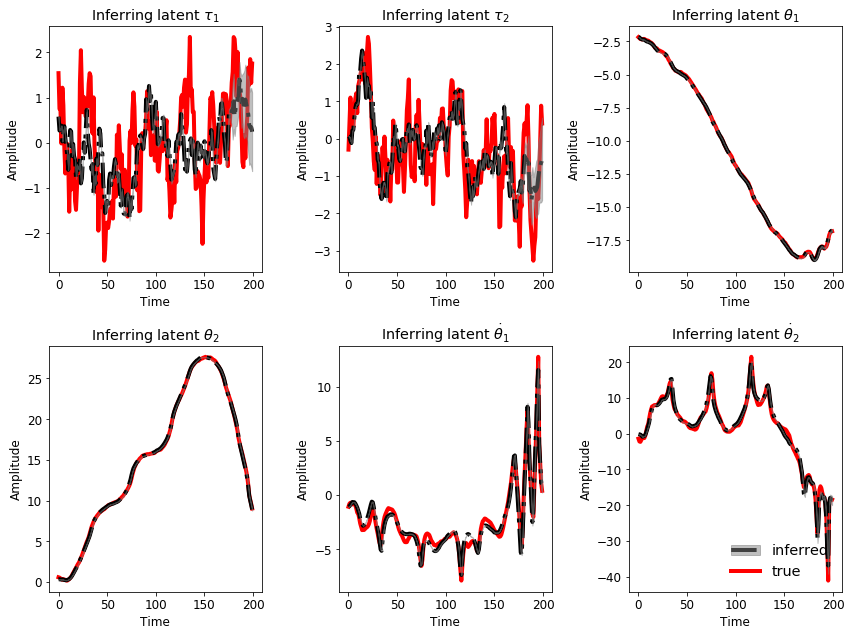

In [45]:
ind_in_batch = 6  # just one batch
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(posterior_summary["smooth_mean"].shape[1]):
    if i == 5:
        plt_leg = True
    arm_utils.plot_posterior_trace(
        post_mean=weighted_mean[i, :],
        post_var=np.sqrt(weighted_var[i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_dict_full["state"][i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
fig.tight_layout()
plt.savefig(plot_folder + '/FFBS_BPF_infer_latents.png')

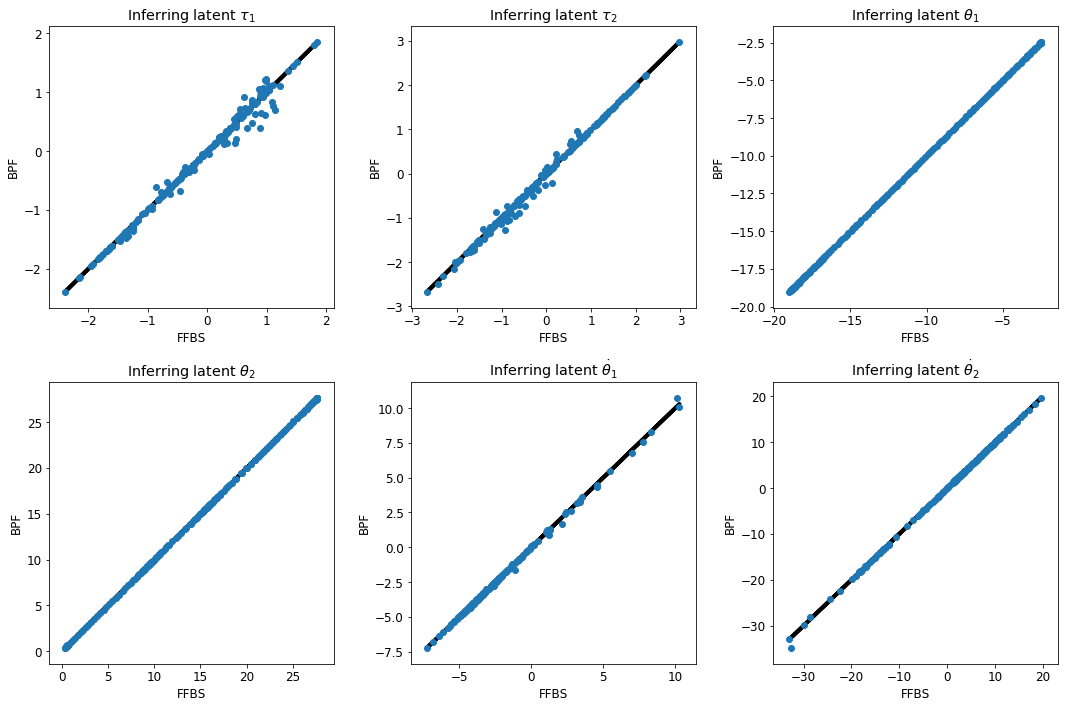

In [41]:
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
nrows = 2
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,10), sharey=False)
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(smooth_mean[ind_in_batch,i,:], 
                smooth_mean[ind_in_batch,i,:], 'k') # diag line
    axs[i].scatter(smooth_mean[ind_in_batch,i,:], 
            posterior_summary["smooth_mean"][ind_in_batch,i,:], 
                   zorder=3)
    axs[i].set_xlabel('FFBS')
    axs[i].set_ylabel('BPF')
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title("Inferring latent " +  label_dict_full["state"][i])

fig.tight_layout()
plt.savefig(plot_folder+'/compare_FFBS_BPF.png')

Learn static parametrs: $L_1$, $L_2$, $M_1$ and $M_2$

In [26]:
empirical_estimate_L1 = np.linalg.norm(sim_data_np[0, 2:4, :] -
                                       sim_data_np[0, :2, :],
                                       axis=0)
empirical_estimate_L2 = np.linalg.norm(sim_data_np[0, 4:, :] -
                                       sim_data_np[0, 2:4, :],
                                       axis=0)

In [27]:
percent_error_L1_hat = (inits_dict["L1"] - np.median(empirical_estimate_L1)) / inits_dict["L1"]
percent_error_L2_hat =(inits_dict["L2"] - np.median(empirical_estimate_L2)) / inits_dict["L2"]

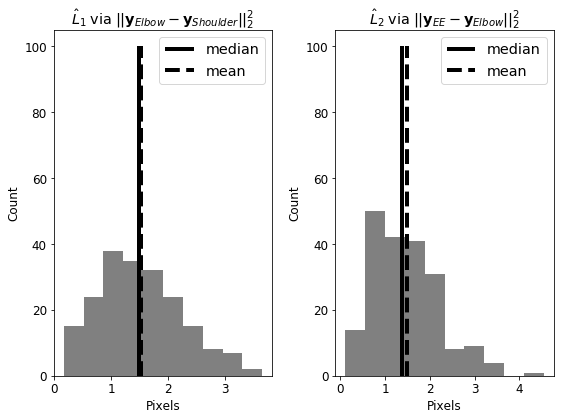

L1 true = 1.00, L2 true = 1.00
percent error L1 hat = -0.49, percent error L2 hat = -0.39
Observation noise scale = 0.50


<Figure size 576x432 with 0 Axes>

In [28]:
arm_utils.plot_empirical_norms_hist(empirical_estimate_L1, empirical_estimate_L2,
                          os.path.join(plot_folder, 'empirical_norms'));
print('L1 true = %.2f, L2 true = %.2f' % (inits_dict["L1"], inits_dict["L2"]))
print('percent error L1 hat = %.2f, percent error L2 hat = %.2f' %
      (percent_error_L1_hat, percent_error_L2_hat))
print('Observation noise scale = %.2f' % emission_var_diag)

In [90]:
learning_inits_dict = {}
'''perturb the true inits before training'''
learning_inits_dict['L1'] = inits_dict["L1"] + 0.2 # for now, can be empirical estimate or learned
learning_inits_dict['L2'] = inits_dict["L2"] - 0.3 # same
learning_inits_dict['M1'] = inits_dict["M1"] - 0.2 # test init for true == 1.1
learning_inits_dict['M2'] = inits_dict["M2"] + 0.1 # test init for true == 1.1

In [91]:
arm_model_learning = planar_arm_dyn_model.PlanarArmDyn(
    dt=dt,
    inits_dict=learning_inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=True,
    constrain_phase_space=False,
    torque_dyn="Langevin")
# below is an attempt to scale Langevin_lambda with the transition force scale
arm_model_learning.Langevin_lambda = transition_force_scale * .3 # was * .3
arm_model_learning.Langevin_lambda

6.0

In [92]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(1.2000, requires_grad=True),
 Parameter containing:
 tensor(0.7000, requires_grad=True),
 Parameter containing:
 tensor(0.3000, requires_grad=True),
 Parameter containing:
 tensor(0.4000, requires_grad=True)]

In [94]:
learning_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
here we learn M1 and M2'''

learning_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

learning_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_learning)

learning_model["emission"] = planar_arm_dyn_model.Emission(learning_inits_dict,
                                                       np.eye(6) *
                                                       emission_var_diag,
                                                        arm_model_learning,
                                                       theta_indices=[2, 3])

learning_model["proposal"] = proposal_objects.Bootstrap_Proposal( \
                               learning_model["initial"], learning_model["transition"])

In [95]:
# running params
num_timesteps = 100
saving_interval = 10
logging_interval = 1
batch_size = 2 # 64 is good for independent SMC. the higher the better.
num_iterations = 30
num_particles = 500
num_epochs = 40

In [96]:
dataloader = train.get_synthetic_dataloader(
            full_model["initial"],
            full_model["transition"],
            full_model["emission"],
            num_timesteps, batch_size)

In [97]:
# ToDo: look at the aesmc original script for training
training_stats = planar_arm_dyn_model.TrainingStats(true_inits_dict=inits_dict,
                arm_model_instance = arm_model_learning,
                num_timesteps = num_timesteps,
                logging_interval = logging_interval)

In [98]:
arm_model_learning.to("cuda" if torch.cuda.is_available() else "cpu")

PlanarArmDyn()

In [100]:
# no need to run. here we can change defs last minute if needed.
for param in list(arm_model_learning.parameters()):
    param.requires_grad = True
print(list(arm_model_learning.parameters()))

[Parameter containing:
tensor(1.2000, requires_grad=True), Parameter containing:
tensor(0.7000, requires_grad=True), Parameter containing:
tensor(0.3000, requires_grad=True), Parameter containing:
tensor(0.4000, requires_grad=True)]


In [31]:
from scipy.special import logsumexp

In [101]:
train.train(dataloader=dataloader,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=num_epochs,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

each batch contains different data.
Epoch 0: Iteration 0: Loss = 712.0127194869663, Param. norm = 0.425718140908663
each batch contains different data.
Epoch 0: Iteration 1: Loss = 695.5613997691509, Param. norm = 0.4267484693642848
each batch contains different data.
Epoch 0: Iteration 2: Loss = 733.3218329383369, Param. norm = 0.426000670573329
each batch contains different data.
Epoch 0: Iteration 3: Loss = 709.7416379609219, Param. norm = 0.4269740409804501
each batch contains different data.
Epoch 0: Iteration 4: Loss = 706.1204418719955, Param. norm = 0.4291952994659673
each batch contains different data.
Epoch 0: Iteration 5: Loss = 727.9535359128904, Param. norm = 0.4311748372965241
each batch contains different data.
Epoch 0: Iteration 6: Loss = 707.2187482565976, Param. norm = 0.4325427959275535
each batch contains different data.
Epoch 0: Iteration 7: Loss = 743.2499683291448, Param. norm = 0.4355435797325991
each batch contains different data.
Epoch 0: Iteration 8: Loss = 6

KeyboardInterrupt: 

In [114]:
params = np.asarray(training_stats.curr_params_list)
print(params)

[[1.19699991 0.69700003 0.29700005 0.39700004]
 [1.19408953 0.69485849 0.29422989 0.39482   ]
 [1.19479728 0.69616961 0.29520735 0.39632061]
 [1.19385779 0.69473487 0.2938441  0.39507332]
 [1.19359124 0.69240242 0.2913999  0.39274031]
 [1.1929487  0.69035989 0.28886724 0.39071107]
 [1.19203675 0.68886274 0.286816   0.38922638]
 [1.19395924 0.68674254 0.28468356 0.3871012 ]
 [1.19590104 0.6846348  0.28256518 0.38498953]
 [1.19747519 0.68312097 0.28103942 0.38348565]
 [1.19645953 0.68101311 0.27942836 0.38122827]
 [1.19499636 0.67900139 0.27798793 0.37905598]
 [1.19378328 0.67746711 0.2768884  0.37739483]
 [1.19281316 0.67630285 0.27605331 0.37613204]
 [1.19207823 0.67542654 0.27542481 0.3751815 ]
 [1.19151533 0.67476743 0.27495146 0.37446645]
 [1.19109273 0.6742714  0.27459714 0.37392867]
 [1.18956029 0.67422777 0.27256072 0.37404874]
 [1.18789017 0.6743449  0.27037129 0.3743746 ]
 [1.18663013 0.67443281 0.26873288 0.37461847]
 [1.18568885 0.67449921 0.26750869 0.37480161]
 [1.18498218 

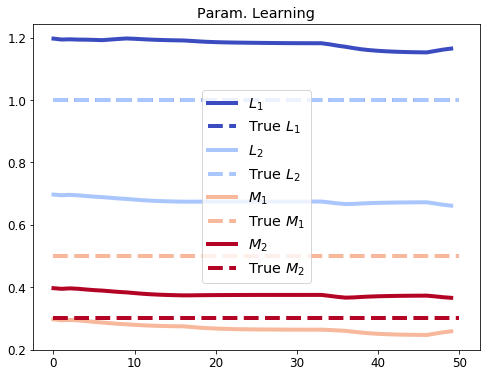

In [104]:
from matplotlib.pyplot import cm
param_label_list = [r"$L_1$", r"$L_2$", r"$M_1$", r"$M_2$"]
key_list = list(inits_dict.keys())
color=iter(cm.coolwarm(np.linspace(0,1,len(key_list))))
for i in range(params.shape[1]):
    c = next(color)
    plt.plot(params[:,i], label = param_label_list[i], c=c)
    plt.plot([0, len(params)], [inits_dict[key_list[i]], inits_dict[key_list[i]]], \
                                label = "True " + param_label_list[i],
            linestyle = "dashed", c=c)
plt.legend()
plt.title("Param. Learning")
plt.savefig(plot_folder + '/param_learning.png')

In [106]:
# plt.title('Parameter Learning')
# plt.plot(params[:,0], label = r"$L_1$")
# plt.plot(params[:,1], label = r"$L_2$")
# plt.plot(params[:,2], label = r"$M_1$")
# plt.plot(params[:,3], label = r"$M_2$")
# plt.plot([0, len(params)], [2.0, 2.0], label = "True length")
# plt.plot([0, len(params)], [inits_dict["M1"], inits_dict["M1"]], label = "True M1")
# plt.plot([0, len(params)], [inits_dict["M2"], inits_dict["M2"]], label = "True M2")

# plt.xlabel('training_iteration/10')
# plt.legend()

$M_1 : = 1, M_2 = \lambda \cdot M_1$ 
since we can init $L$ properly from observations, maybe fix $L$'s and $M_1$ -- can we infer $M_2$?
If this becomes hard, just fix all params and ignore the learning problem.

In [107]:
L1_in_training  = np.zeros(len(training_stats.curr_params_list))
L2_in_training  = np.zeros(len(training_stats.curr_params_list))

for i in range(len(training_stats.curr_params_list)):
    L1_in_training[i] = training_stats.curr_params_list[i][0]
    L2_in_training[i] = training_stats.curr_params_list[i][1]

In [111]:
# plt.title('Parameter Learning')
# plt.plot(L1_in_training, label = r"$L_1$")
# plt.plot(L2_in_training, label = r"$L_2$")
# plt.plot([0, len(L1_in_training)], [inits_dict["L1"], inits_dict["L1"]], 'k', label = "True length")
# plt.xlabel('training_iteration/10')
# plt.legend()

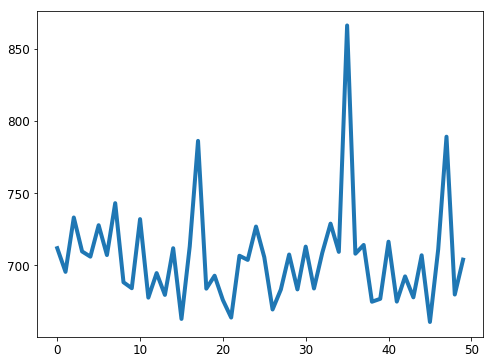

In [112]:
plt.plot(training_stats.loss)